In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 23.3 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import matplotlib.pyplot as plot
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading Inputs**

Here, we input Toronto Travel time data for January 2020 to March 2020. We consider the hourly aggregate for modeling. 

In [ ]:
travel_times = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ETA/Toronto/Travel_Times.csv')
toronto_neighbourhood_hourly = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ETA/Toronto/toronto-neighbourhoods-2020-1-All-HourlyAggregate.csv')

We would like to use hourly travel time average for modeling. Let's use this first, then you can play around with other time-series data!

In [ ]:
travel_times.tail()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds)
136,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",137,"0 Treerun Avenue, Milliken, Scarborough, Toronto","1/1/2020 - 3/31/2020, Every day, Daily Average",1839,1352,2499
137,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",138,"0 Livonia Place, Morningside, Scarborough, Tor...","1/1/2020 - 3/31/2020, Every day, Daily Average",1625,1216,2170
138,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",139,"0 Rolph Road, Leaside, East York, Toronto","1/1/2020 - 3/31/2020, Every day, Daily Average",895,624,1282
139,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",140,"900 York Beltline Trail, Briar Hill - Belgravi...","1/1/2020 - 3/31/2020, Every day, Daily Average",1446,1090,1916
140,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",141,"Water's Edge Promenade, Downtown, Old Toronto,...","1/1/2020 - 3/31/2020, Every day, Daily Average",339,154,742


In [ ]:
toronto_neighbourhood_hourly.head(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,33,135,7,2333.88,884.45,2188.31,1.42
1,132,12,7,1095.12,242.96,1068.57,1.25
2,130,32,7,2164.54,726.59,2051.44,1.39
3,131,22,7,1486.98,412.22,1433.79,1.31
4,66,2,18,2092.00,384.75,2056.50,1.20


Mean travel time in Toronto

Text(0, 0.5, 'Mean travel time in mins')

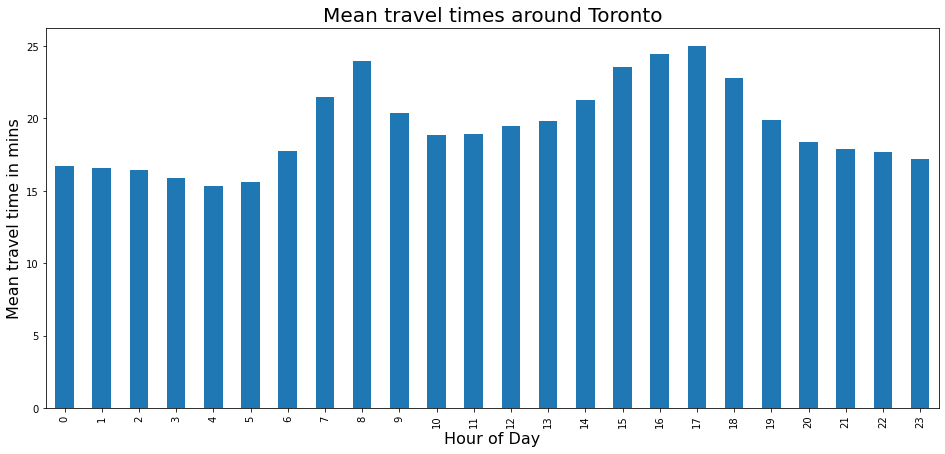

In [ ]:
mean_travel_time_by_hour_of_day = toronto_neighbourhood_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(16,7))
plt.set_title('Mean travel times around Toronto', fontsize=20)
plt.set_xlabel('Hour of Day', fontsize = 16)
plt.set_ylabel('Mean travel time in mins', fontsize = 16)

Mean travel time in Toronto

Text(0, 0.5, 'Std Dev off travel time in mins')

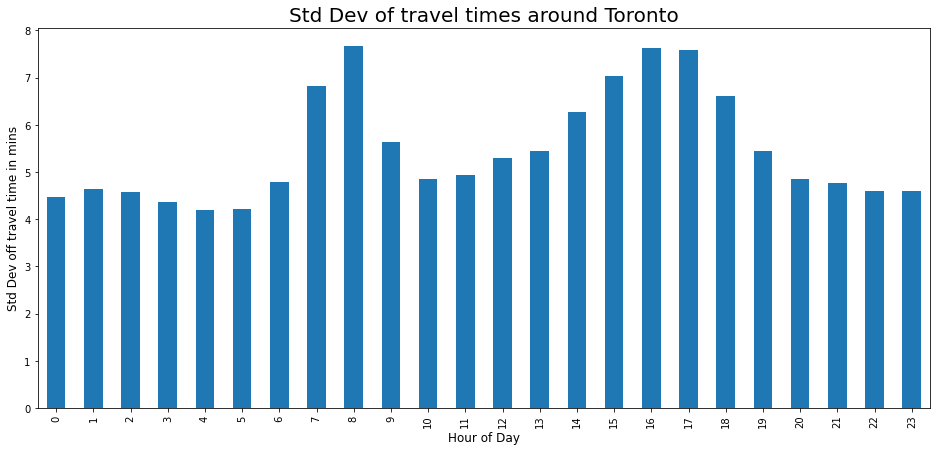

In [ ]:
std_dev_travel_time_by_hour_of_day = toronto_neighbourhood_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_travel_time_by_hour_of_day.plot(kind="bar", figsize = (16,7))
plt.set_title('Std Dev of travel times around Toronto', fontsize =20)
plt.set_xlabel('Hour of Day', fontsize = 12)
plt.set_ylabel('Std Dev off travel time in mins', fontsize = 12)

# **The Json Data (Map)**

Load json data and plot it

In [ ]:
toronto = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/ETA/Toronto/toronto_neighbourhoods.json')

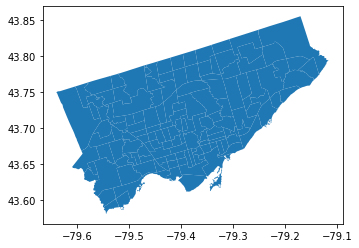

In [ ]:
toronto.plot()

In [ ]:
toronto.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,3,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


# **Picking centroids to represent an area**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


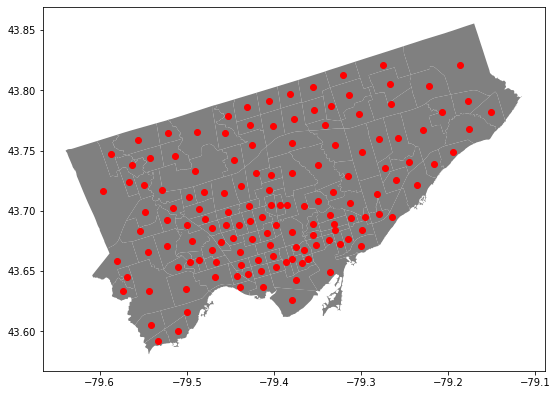

In [ ]:
toronto = toronto.drop(columns=['MOVEMENT_ID'])
toronto_c = toronto.copy()
toronto_c.geometry = toronto_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(9,9))
toronto.plot(color='grey',ax=ax)
toronto_c.plot(color='red',ax=ax)

In [ ]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()

,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."


# Get some random points from each ward to diversify representation

In [ ]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:2]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(toronto)
diversified_points.sample(5)

,DISPLAY_NAME,geometry
37,"0 Rangoon Road, Eringate - Centennial - West D...",POINT (-79.57823 43.67115)
42,"0 McIntosh Street, Cliffside, Scarborough, Tor...",POINT (-79.28626 43.68659)
302,"1900 Lawrence Avenue East, Wexford, Scarboroug...",POINT (-79.31696 43.76722)
39,"0 Duncairn Road, Don Mills, North York, Toronto",POINT (-79.34394 43.73999)
205,"100 Torbrick Road, East Danforth, Old Toronto,...",POINT (-79.32530 43.66258)


In [ ]:
diversified_points.shape

(423, 2)

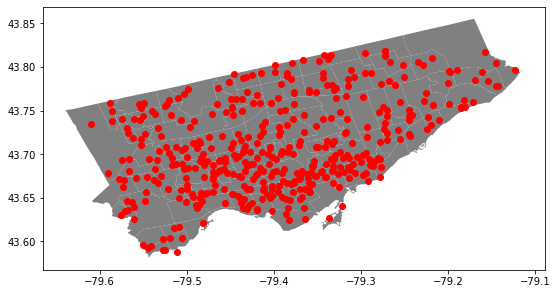

In [ ]:
fig, ax = plot.subplots(figsize=(9,9))
toronto.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

# Cleaning up data for analysis
Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [ ]:
time_df = pd.merge(toronto_neighbourhood_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
279984,141,140,20,1518.76,284.21,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279974,141,140,21,1528.77,300.13,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279980,141,140,22,1481.58,303.79,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279972,141,140,23,1431.77,301.57,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
369895,141,141,23,297.76,229.63,"Water's Edge Promenade, Downtown, Old Toronto,...","Water's Edge Promenade, Downtown, Old Toronto,..."


In [ ]:
toronto_c.shape

(141, 2)

In [ ]:
diversified_points.shape

(423, 2)

In [ ]:
full_toronto = toronto_c.append(diversified_points, ignore_index=True)
full_toronto.shape

(564, 2)

In [ ]:
full_toronto.head()

,DISPLAY_NAME,geometry
0,"York University Busway, York University Height...",POINT (-79.48888 43.76574)
1,"0 Hambly Avenue, The Beach, Old Toronto, Toronto",POINT (-79.29960 43.67105)
2,"3400 Kingston Road, Scarborough Village, Scarb...",POINT (-79.21681 43.73865)
3,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto",POINT (-79.43934 43.63670)
4,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...",POINT (-79.33565 43.64929)


In [ ]:
time_df2 = pd.merge(time_df, full_toronto, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, full_toronto, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Geometry,Destination Geometry
3963176,82,93,21,807.44,327.10,"100 Hazelton Avenue, Midtown Toronto, Old Toro...","0 East Liberty Street, Liberty Village, Old To...",POINT (-79.40301 43.67447),POINT (-79.41242 43.63668)
1087128,71,28,1,260.80,209.93,"0 Corwin Crescent, Wilson Heights, North York,...","0 Liscombe Road, Rustic, North York, Toronto",POINT (-79.45478 43.74868),POINT (-79.49809 43.71161)
2563899,52,62,22,376.49,151.86,"0 West Toronto Street, The Junction, York, Tor...","0 Nairn Avenue, Earlscourt, York, Toronto",POINT (-79.46970 43.67181),POINT (-79.44748 43.67775)


In [ ]:
time_df2.shape

(6334176, 9)

Create function to save model and file checking, and define output path

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

output_path = '/content/drive/MyDrive/Colab Notebooks/ETA/Toronto/Output/'

Create distance feature between two points

In [ ]:
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2

In [ ]:
filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, output_path + filename)
except:
    pass
  

In [ ]:
final_df.head()

,Source lat,Source long,Dest lat,Dest long,hod,Geodesic Distance,mean_travel_time
0,43.765737,-79.488883,43.765737,-79.488883,23,0.000000,264.18
1,43.765737,-79.488883,43.770078,-79.500575,23,1.057788,264.18
2,43.765737,-79.488883,43.759129,-79.502246,23,1.302703,264.18
3,43.765737,-79.488883,43.764668,-79.494915,23,0.500081,264.18
4,43.770078,-79.500575,43.765737,-79.488883,23,1.057788,264.18


# Modeling


Train and test splitting

In [ ]:
X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

#MLP Regressor with Sklearn

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=100).fit(X_train, y_train)

In [ ]:
import numpy as np

predictions = regr.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.6233387159684454

MSE: 107636.85853804508

RMSE: 328.080567144787

MAE: 255.21500604973184



In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


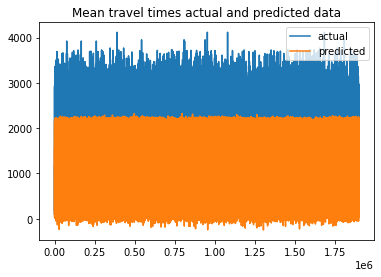

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="actual")
plt.plot(x_ax, predictions, label="predicted")

plt.title("Mean travel times actual and predicted data")

plt.legend()
plt.show()

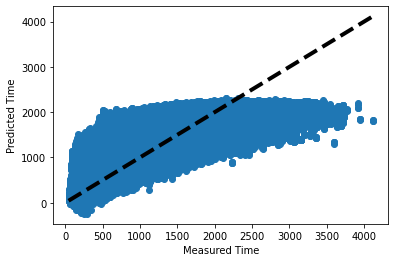

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plt.show()

## KNN

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV

filename_knn = 'KNN_model_RandomSearch.bin'
path_knn = output_path + filename_knn
if file_exists(path_knn):
    with open(path_knn, 'rb') as file:
        model_knn = pickle.load(file)
else:
  params = {'n_neighbors':list(range(5,30)), 'leaf_size': list(range(1,50)), 
          'p':[1,2], 'weights': ['uniform','distance']}
  knn = neighbors.KNeighborsRegressor()
  model_knn = RandomizedSearchCV(knn, params, cv=5)
  model_knn.fit(X_train,y_train)

Prediction with evaluation metrics (R2, MSE, RMSE, MAE)

In [ ]:
predictions_knn = model_knn.predict(X_test)

print('R2: {}\n'.format(metrics.r2_score(y_test, predictions_knn)))

print('MSE: {}\n'.format(metrics.mean_squared_error(y_test, predictions_knn)))

print('RMSE: {}\n'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions_knn))))

print('MAE: {}\n'.format(metrics.mean_absolute_error(y_test, predictions_knn)))


R2: 0.8618160387023024

MSE: 39488.23020839312

RMSE: 198.71645681320186

MAE: 151.12988920055776



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


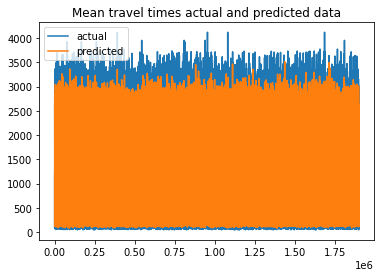

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions_knn, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

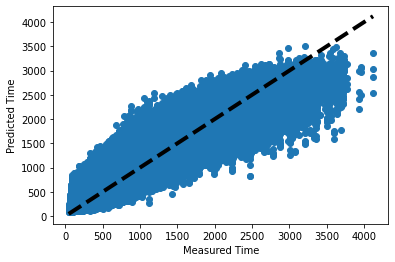

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions_knn)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## XGBOOST

In [ ]:
import xgboost as xgb

filename_xgb = 'XGB_model_500_best.bin'
path_xgb = output_path + filename_xgb
if file_exists(path_xgb):
    with open(path_xgb, 'rb') as file:
        model_xgb = pickle.load(file)
else:
  parameters = {'n_estimators':[100,500],
              'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.05, 0.1, 0.25, 0.5], 
              'max_depth': [7,8,10,11],
              'min_child_weight': [5,10,15,20],
              'colsample_bytree': [0.5, 0.8, 1],
              'n_estimators': [20,40,60,100],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3],
              'n_jobs' : [2,4,6]}
  xgb_reg = XGBRegressor(random_state=30)
  model_xgb = RandomizedSearchCV(xgb_reg,parameters, cv=3,n_iter=9,
                                 scoring='neg_mean_absolute_error',verbose=3)
  model_xgb.fit(X_train,y_train,verbose = 1)

Feature Importance

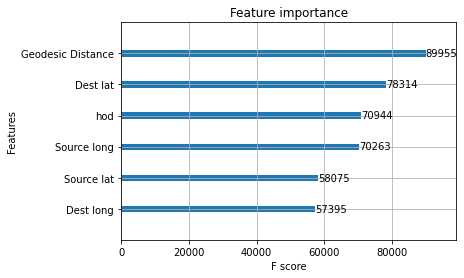

In [ ]:
xgb.plot_importance(model_xgb)

Prediction with evaluation metrics (R2, MSE, RMSE, MAE)

In [ ]:
predictions_xgb = model_xgb.predict(X_test)

from sklearn import metrics

print('R2: {}\n'.format(metrics.r2_score(y_test, predictions_xgb)))

print('MSE: {}\n'.format(metrics.mean_squared_error(y_test, predictions_xgb)))

print('RMSE: {}\n'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb))))

print('MAE: {}\n'.format(metrics.mean_absolute_error(y_test, predictions_xgb)))


R2: 0.9670097594716733

MSE: 9427.477692626617

RMSE: 97.09519912244177

MAE: 69.89266147227394



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


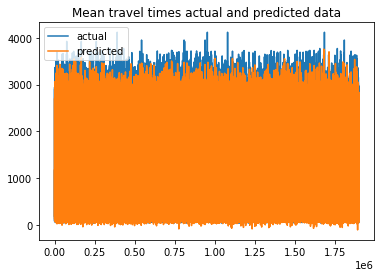

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions_xgb, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

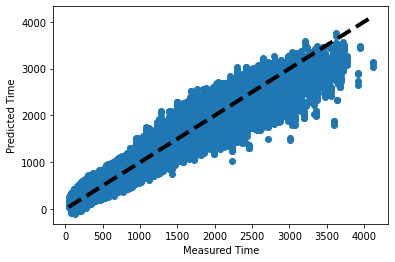

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions_xgb)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

filename_rf = 'RandomForest_model.bin'
path_rf = output_path + filename_rf
if file_exists(path_rf):
    with open(path_rf, 'rb') as file:
        model_rf = pickle.load(file)
else:
  random_grid = {'bootstrap': [True, False],
                 'n_estimators': [10,20,30]}
  rf_reg = RandomForestRegressor()
  model_rf = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid, 
                                n_iter=100, cv = 3, verbose=2, 
                                random_state=42, n_jobs = -1)
  model_rf.fit(X_train,y_train,verbose = 1)

Feature Importance

<BarContainer object of 6 artists>

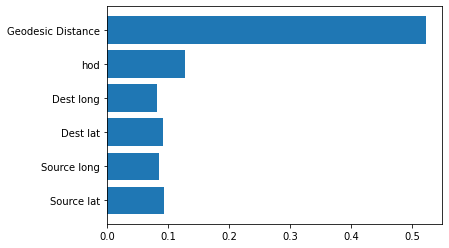

In [ ]:
plot.barh(X.columns, model_rf.feature_importances_)

Prediction with evaluation metrics (R2, MSE, RMSE, MAE)

In [ ]:
predictions_rf = model_rf.predict(X_test)

from sklearn import metrics

print('R2: {}\n'.format(metrics.r2_score(y_test, predictions_rf)))

print('MSE: {}\n'.format(metrics.mean_squared_error(y_test, predictions_rf)))

print('RMSE: {}\n'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions_rf))))

print('MAE: {}\n'.format(metrics.mean_absolute_error(y_test, predictions_rf)))


R2: 0.9831155559235739

MSE: 4824.994220525079

RMSE: 69.46217834566578

MAE: 25.00668189762109



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


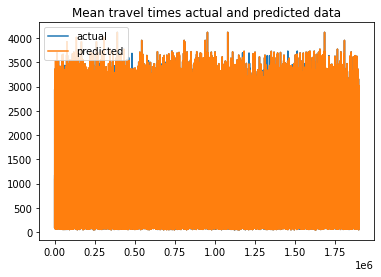

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions_rf, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

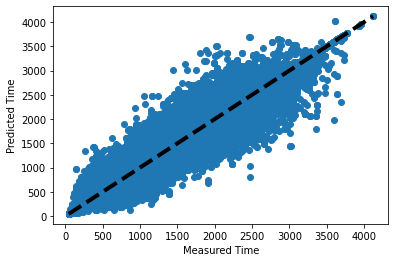

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions_rf)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## Testing with some random points
We use Random Forest and XGBoost model as the best model for testing some random points

In [ ]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, hod, distance]])
    
def predict(df, model):
    return model.predict(df[features])

In [ ]:
def compare(actual, predicted):
    return pd.DataFrame(data = {'actual': actual, 'prediction': predicted})

In [ ]:
def get_random_points_in_bangalore(number):
    points = []
    min_x, min_y, max_x, max_y = 12.85, 77.45, 13.0, 77.75  
    i= 0
    while i < number:
        point = (random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        i += 1
        points.append(point)
    return points

In [ ]:
points = [((43.7032065069154, -79.3017668023782), #Harcon Construction, 5 Curran Dr, East York, ON M4B 3K8, Canada
 (43.79372795068623, -79.53055708277108)), #Smartcentres Subway Parking, Vaughan, ON L4K 5Z5, Canada

 ((43.68026755339931, -79.18913204546007), #Lake Ontario
 (43.67670568483283, -79.37746517790657)), #24 Dunbar Rd, Toronto, ON M4W 2X6, Canada

 ((43.74896672433117, -79.57967946899988), #155 Rowntree Mill Rd, North York, ON M9L 1C9, Canada
 (43.71968777481803, -79.5454589216665)), #Rexdale, Toronto, ON, Canada

 ((43.72249408273731, -79.3217561447087), #Bermondsey, Toronto, ON, Canada
 (43.74190761585928, -79.5548316805303)), # 4 Delabra Rd, Etobicoke, On M9V 2M7, Canada

 ((43.7624005139969, -79.28526940452026), #8 Glaive Dr, Scarborough, ON M1P 1X6, Canada
 (43.821413225775, -79.23492559977723)), #Verge Furniture Logistics Inc, 257 Finchdene Square, Scarborough, ON M1X 1B9, Canada

 ((43.7771098764595, -79.59413098212778), #38 Graceview Ct, Woodbridge, ON L4L 9C4, Canada
 (43.77481420996121, -79.43885522276555)), #Willowdale, North York, ON M2R 1M9, Canada

 ((43.64701148871478, -79.42847268020157), #149 Gladstone Ave, Toronto, ON M6J 3L1, Canada
 (43.71016452363984, -79.42515908034015)), #Midtown Toronto, North York, ON M5N 1R4, Canada

 ((43.720770127049946, -79.4853550076423), #Maple Leaf, Toronto, ON M6L 3G4, Canada
 (43.6243899135311, -79.39389416437574)), #Toronto, Ontario M5V 1A1, Canada

 ((43.678142257463314, -79.33132190637777), #Greenwood Ave at Felstead Ave, Toronto, ON M4J 4Y5, Canada
 (43.736450380536866, -79.36182952465279)), ##23 Brian Cliff Dr, North York, ON M3B 2G1, Canada

 ((43.60311188732751, -79.55000571296699), #34 Eltham Dr, Etobicoke, ON M8W 2J2, Canada
 (43.70087649163705, -79.28227813882049))] #Toronto, Ontario, Canada


hours_of_day = [18, 7, 18, 2, 16, 23, 10, 8, 4, 16]

In [ ]:
# taking average of thetime bounds given by manual google maps travel times for same coordinates and departure time
travel_times_gmaps_in_mins = [34, 31, 18, 32, 20, 28, 27, 55, 14, 49]
travel_times_gmaps = [t*60 for t in travel_times_gmaps_in_mins]

Test with XGBoost Model

In [ ]:
travel_times_model_xgb = []
points1 = [p[0] for p in points]
points2 = [p[1] for p in points]
for point1, point2, hod in zip(points1, points2, hours_of_day):
    lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
    p = predict(prepare_df(lat1, long1, lat2, long2, hod), model_xgb)
    p = p.tolist()[0]
    travel_times_model_xgb.append(p)
[t/60 for t in travel_times_model_xgb]

[35.80687255859375,
 32.48752237955729,
 6.748965454101563,
 22.507356770833333,
 6.853863016764323,
 23.430474853515626,
 21.783807373046876,
 30.343780517578125,
 11.010026041666666,
 40.971171061197914]

In [ ]:
compare(travel_times_gmaps, travel_times_model_xgb)

,actual,prediction
0,2040,2148.412354
1,1860,1949.251343
2,1080,404.937927
3,1920,1350.441406
4,1200,411.231781
5,1680,1405.828491
6,1620,1307.028442
7,3300,1820.626831
8,840,660.601562
9,2940,2458.270264


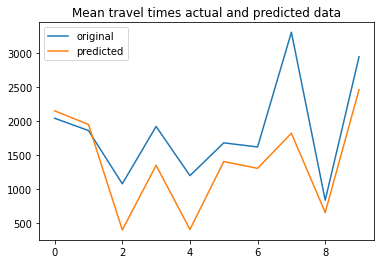

In [ ]:
x_ax = range(len(travel_times_model_xgb))
plot.plot(x_ax, travel_times_gmaps, label="original")
plot.plot(x_ax, travel_times_model_xgb, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

Test with RandomForest Model

In [ ]:
travel_times_model_rf = []
points1 = [p[0] for p in points]
points2 = [p[1] for p in points]
for point1, point2, hod in zip(points1, points2, hours_of_day):
    lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
    p = predict(prepare_df(lat1, long1, lat2, long2, hod), model_rf)
    p = p.tolist()[0]
    travel_times_model_rf.append(p)
[t/60 for t in travel_times_model_rf]

[38.49516666666666,
 35.37215,
 8.351066666666666,
 21.625333333333337,
 9.1515,
 18.33573333333333,
 24.547800000000002,
 29.14333333333333,
 12.170950000000001,
 40.881333333333345]

In [ ]:
compare(travel_times_gmaps, travel_times_model_rf)

,actual,prediction
0,2040,2309.710
1,1860,2122.329
2,1080,501.064
3,1920,1297.520
4,1200,549.090
5,1680,1100.144
6,1620,1472.868
7,3300,1748.600
8,840,730.257
9,2940,2452.880


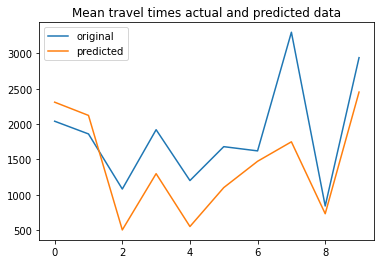

In [ ]:
x_ax = range(len(travel_times_model_rf))
plot.plot(x_ax, travel_times_gmaps, label="original")
plot.plot(x_ax, travel_times_model_rf, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()